#  sample and cluster PMIDs from a single year
###  export PMIDs grouped by cluster, with umap coordinates for convenience

todo on the next pass, use ~5D umap coords and multiple samples

In [3]:
import pymysql
import pickle
import json

import math
import numpy as np
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'

import time
import hdbscan


### control params

In [4]:
target_file = 'data_processing_feb2020/pmids_2018_250k.json'  # name to assign exported results

K_sample = 250000   # rule of thumb - at least 5K samples per cluster for abstracts analysis
                   #                 - at least 25K samples per cluster for titles analysis

N_samplesets = 3
year = 2018
path2dir = '/home/brendan/FastData/pubmed2019/pubmed_data_processing/year_pmids/'  # knowledge-garden
        #path2dir = '/project2/jevans/brendan/pubmed_data_processing/year_pmids/'  # RCC Midway2

### set up mysql connection

In [5]:
config_path = '/home/brendan/Projects/AttentionWildfires/attention_wildfires/mysql_config.json'
db_name = 'test_pubmed'  # db name collisons? https://stackoverflow.com/questions/14011968/user-cant-access-a-database
                        # todo should move this db_name into config file
with open(config_path, 'r') as f:
    config_data = json.load(f)
    
client_config = {'database': db_name,
                'user': config_data['user'],
                 'password': config_data['lock']}

## init db connection
db = pymysql.connect(**client_config)


### load the pre-fit umap model (trained on time-flattened data)

In [6]:
print('pop open pickle jar: umap model...')
umap_path = "/home/brendan/FastData/pubmed2019/pubmed_data_processing/dimensionality_reduction_models/umap2D/umap_model0.pkl"
with open(umap_path, 'rb') as file:
    umap_model = pickle.load(file)

pop open pickle jar: umap model...


### load the precomputed set of pmids for this year

In [7]:
filename = 'pubmed_state_{}'.format(year)
path2pmids = path2dir + filename
with open(path2pmids,'r') as f:
    data = json.load(f)

year_pub_pmids = data['publications']
N_pubs = len(year_pub_pmids)
print("N pubs: {}".format(N_pubs))
del data # clean up


N pubs: 1205220


### generate sample indices

In [8]:
samples = {}
for i in range(N_samplesets):
    samples[i] = {}
    samples[i]['pmids'] = np.random.choice(year_pub_pmids, K_sample)

### helper function for selecting embedding coordinates (for density based clustering)

In [9]:
def get_embedding_vectors(sample_pmids):
    start_time = time.time()
        
    str_fmt = ', '.join([str(pmid) for pmid in sample_pmids])
    sql = '''SELECT E.pmid, E.embedding
            FROM scibert_mean_embedding as E
            WHERE E.pmid IN ({})'''.format(str_fmt)
    cursor = db.cursor()
    cursor.execute(sql)
    
    pub_embeddings = []
    pub_pmids = []
    for i,row in enumerate(cursor):
        pub_pmids.append(row[0])
        pub_embeddings.append(np.frombuffer(row[1],dtype='float16').tolist())
    cursor.close()
    
    end_time = time.time()
    elapsed = end_time - start_time
    print("SQL query composed and executed in {} s".format(elapsed))
    
    return pub_pmids, pub_embeddings

### use sample indices to fetch embedding coordinates & compress with umap

In [10]:
for i in range(N_samplesets):
    pmids, embeddings = get_embedding_vectors(samples[i]['pmids'])
    samples[i]['pmids'] = pmids  # remove pmids with no corresponding embedding (e.g. no abstract)
    samples[i]['raw_coordinates'] = embeddings
    print('compressing...')
    samples[i]['umap2D'] = umap_model.transform(embeddings)

/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (3170, "Memory capacity of 8388608 bytes for 'range_optimizer_max_mem_size' exceeded. Range optimization was not done for this query.")
  result = self._query(query)


SQL query composed and executed in 47.32489895820618 s
compressing...


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../brendanchambers/.conda/envs/embedding-base/lib/python3.7/site-packages/umap/nndescent.py", line 123:
<source missing, REPL/exec in use?>

  state.func_ir.loc))
/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../brendanchambers/.conda/envs/embe

SQL query composed and executed in 41.074429988861084 s
compressing...


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (3170, "Memory capacity of 8388608 bytes for 'range_optimizer_max_mem_size' exceeded. Range optimization was not done for this query.")
  result = self._query(query)


SQL query composed and executed in 41.200634717941284 s
compressing...


### sanity check - compare umap plots of the samples

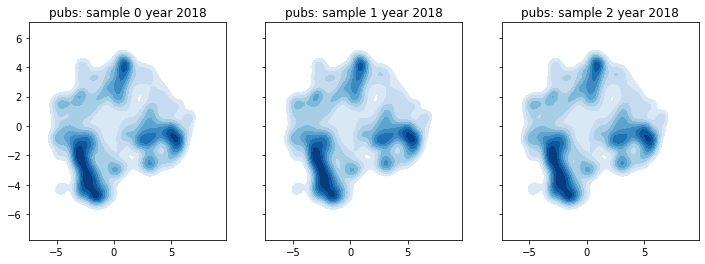

In [11]:
try:
    (f, ax) = plt.subplots(1,
                           N_samplesets,
                           sharex='all', sharey='all',
                           figsize=(12,4))

    for i_sample in range(N_samplesets):

        sns.kdeplot(samples[i_sample]['umap2D'][:,0], # these are pca'd
                    samples[i_sample]['umap2D'][:,1],
                    ax=ax[i_sample],
                    shade=True,
                    shade_lowest=False,
                    cmap='Blues')
        ax[i_sample].set_title('pubs: sample {} year {}'.format(i_sample, year))
except:
    # subplot grid will fail if there is only one sample
    
    plt.figure()
    i_sample = 0
    sns.kdeplot(samples[i_sample]['umap2D'][:,0], # these are pca'd
                        samples[i_sample]['umap2D'][:,1],
                        shade=True,
                        shade_lowest=False,
                        cmap='Blues')
    plt.title('pubs: sample {} year {}'.format(i_sample, year))

### cluster with hdbscan

num clusters: 5


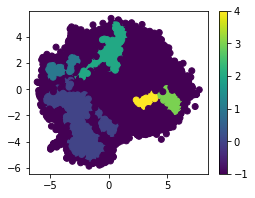

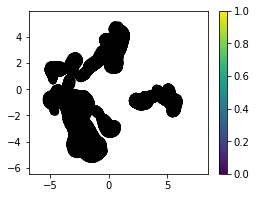

num clusters: 5


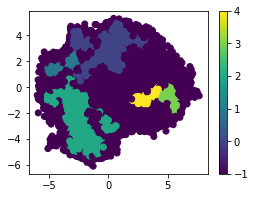

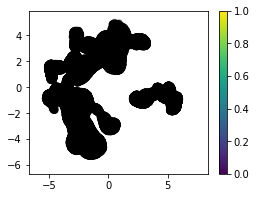

num clusters: 5


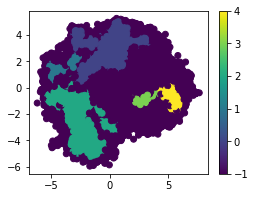

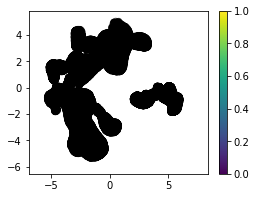

In [12]:
# compare clustering results across the two samples
clustering_scale = int(K_sample * 0.02)
min_samples_param = int(np.min([1000, clustering_scale]))

clusterers = {}
for i in range(N_samplesets):
    clusterers[i] = hdbscan.HDBSCAN(min_cluster_size=clustering_scale, # 500 for 25K # 1000 for 50K # 50 fro 2000
                            min_samples=min_samples_param,   # 500, 1000, 50
                            cluster_selection_method='leaf')  # euclidean distance
    clusterers[i].fit(samples[i]['umap2D'])  # samples x features

    # number of clusters
    print('num clusters: {}'.format(clusterers[i].labels_.max()+1))
    
    # plot clusters
    plt.figure(figsize=(4,3))
    plt.scatter(samples[i]['umap2D'][:,0],
               samples[i]['umap2D'][:,1],
               c=clusterers[i].labels_)
    plt.colorbar()
    plt.show()

    # plot clusters using probabilities_ estimate  (todo combine plots)
    rgba = np.zeros( (np.shape(samples[i]['umap2D'])[0], 4) )
    rgba[:,3] = clusterers[i].probabilities_
    plt.figure(figsize=(4,3))
    plt.scatter(samples[i]['umap2D'][:,0],
               samples[i]['umap2D'][:,1],
               c=rgba)
    plt.colorbar()
    plt.show()


In [13]:
# normalize labels (for easier aggregation in postprocessing)

num clusters: 5
[12.36598831425515, 16.417841785956757, 1.3046732879816916, 5.533850763477169, 6.319177137169581]
[3 4 0 1 2]


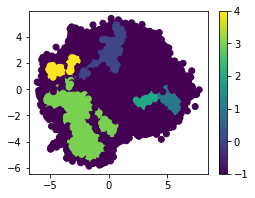

num clusters: 5
[0.31692442182571, 16.415683277881573, 12.364669202597609, 5.532840094095233, 6.3230839358575395]
[0 4 3 1 2]


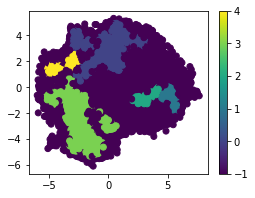

num clusters: 5
[0.31551154221432365, 16.427651318369758, 12.363893784967713, 6.311168418749911, 5.531004058953887]
[0 4 3 2 1]


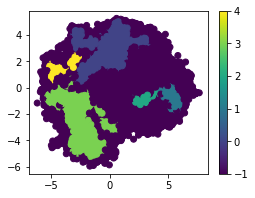

In [20]:
# assign label ID using appx clockwise angle, break ties with radius

R_MAX = 10
def serialize_point(x,y):
    theta = math.atan2(x,y)
    theta = theta / math.pi # rescale onto (-1,1)
    if theta < 0:  # restitch 0-angle
        theta = theta + 2
    theta = round(theta,1) # limit precision of theta and break ties with r
    r = math.sqrt(x*x + y*y)
    r = r / R_MAX  # rescale onto (0,1)
    score = 10*theta + r  # use angle first, break ties with radius
    return score

# sanity testing
'''
print(serialize_point(0,0))
print(serialize_point(0,1))
print(serialize_point(1,1))
print(serialize_point(1,0))
print(serialize_point(-1,-1))
print(serialize_point(-1,0))
plt.scatter([0,0,1,1,-1,-1],[0,1,1,0,-1,0])
'''

for i in range(N_samplesets):

    # number of clusters
    N_clusters = int(clusterers[i].labels_.max()+1)
    print('num clusters: {}'.format(N_clusters))
    
    # get summary coordinate for each cluster
    #cluster_mean = np.zeros( (N_clusters, 2))  # x,y (would be better to use median though)
    cluster_median = np.zeros( (N_clusters, 2))  # x,y (would be better to use median though)
    for i_cluster in range(N_clusters):
        total_points = 0
        vector_sum = np.zeros((1,2))
        
        convenience_xx, convenience_yy = [], []
        for i_label, label in enumerate(clusterers[i].labels_):
            # do nothing for labels of -1
            if label==i_cluster:
                convenience_xx.append(samples[i]['umap2D'][i_label,0])
                convenience_yy.append(samples[i]['umap2D'][i_label,1])
                
        median_x = np.median(convenience_xx)
        median_y = np.median(convenience_yy)
        cluster_median[i_cluster,:] = (median_x, median_y)                                
                
                #total_points += 1
                #vector_sum += [samples[i]['umap2D'][i_label,0],
                #               samples[i]['umap2D'][i_label,1]]  # if this is higher D just use first two dimensions
        #cluster_mean[i_cluster,:] = 1.0*vector_sum / total_points
    
    # sanity check
    #plt.figure()
    #plt.scatter(cluster_mean[:,0],cluster_mean[:,1],marker='x')
    
    # use summary coordinate to order the clusters based on a serialization function
    cluster_scores = []
    for i_cluster in range(N_clusters):
        #score = serialize_point(cluster_mean[i_cluster,0],  # apply custom ordering function
        #                        cluster_mean[i_cluster,1])
        score = serialize_point(cluster_median[i_cluster,0],
                               cluster_median[i_cluster,1])
        cluster_scores.append(score)
    # sort ascending
    print(cluster_scores)
    new_labels = np.argsort(np.argsort(cluster_scores))
    print(new_labels)
    
    # re-assign labels after normalizing integer names for consistency
    num_samples = len(clusterers[i].labels_)
    newlabels_ = np.zeros( (num_samples,) )
    for i_label, old_label in enumerate(clusterers[i].labels_):
        if old_label==-1:
            newlabels_[i_label] = -1
        else:
            newlabels_[i_label] = new_labels[old_label]
    #clusterers[i].labels_ = labels_
        
    # plot clusters
    plt.figure(figsize=(4,3))
    plt.scatter(samples[i]['umap2D'][:,0],
               samples[i]['umap2D'][:,1],
               c=newlabels_) #clusterers[i].labels_)
    plt.colorbar()
    plt.show()


###  format for export

In [21]:


pmids = {}  # for export
summary_coords = {}
for i_sample in range(N_samplesets):
    print("sample {}".format(i_sample))
    
    pmids[i_sample] = {}   # for export
    summary_coords[i_sample] = {}
    
    sample_pmids = np.array(samples[i_sample]['pmids'])  # for convenience, cast list -> np array
    sample_coords = np.array(samples[i_sample]['umap2D'])
    
    k_clusters = clusterers[i_sample].labels_.max() + 1
    for i_cluster in range(k_clusters):
              
        cluster_pmids = sample_pmids[clusterers[i_sample].labels_ == i_cluster]    
        cluster_coords = sample_coords[clusterers[i_sample].labels_ == i_cluster]
        print(np.shape(cluster_coords))
        
        pmids[i_sample][i_cluster] = cluster_pmids.tolist()   # format for export
        summary_coords[i_sample][i_cluster] = cluster_coords.tolist()
                

sample 0
(55208, 2)
(5537, 2)
(20373, 2)
(10138, 2)
(6944, 2)
sample 1
(31124, 2)
(6148, 2)
(54826, 2)
(10535, 2)
(7536, 2)
sample 2
(32442, 2)
(6039, 2)
(55672, 2)
(5934, 2)
(10516, 2)


### export results

In [22]:
save_obj = {'pmids': pmids,
            'summary_coords': summary_coords}

with open(target_file,'w') as f:
    json.dump(save_obj, f, indent=2, sort_keys=True)
